In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [4]:
NUM_PARTICLES = 10_000

# Dimensions in milimeters
BOUNDS_ESPESSURE = (0.2, 1.5)  # mm
BOUNDS_DIAMETER = (10, 50)  # mm
BOUNDS_POSITION = (0, 1000)  # m

NUM_SENSORS = 6
NUM_PARAMETERS = 3
NUM_VARIABLES = NUM_SENSORS * NUM_PARAMETERS

ESPESSURE_INDEX = 0
DIAMETER_INDEX = 1
POSITION_INDEX = 2

NUM_ITERATIONS = 5_000
EARLY_STOPPING_PATIENCE = 30

w = 0.5
c1 = 1
c2 = 3

In [5]:
def generate_sensor():
    return [
        np.random.uniform(*BOUNDS_ESPESSURE),
        np.random.uniform(*BOUNDS_DIAMETER),
        np.random.uniform(*BOUNDS_POSITION),
    ]

In [6]:
def circles_intersect(center1, diameter1, center2, diameter2):
    radius1 = diameter1 / 2
    radius2 = diameter2 / 2
    dist = abs(center1 - center2)

    return dist <= (radius1 + radius2)

In [7]:
def get_elements_in_chunks(lst, chunk_size=NUM_PARAMETERS):
    return [lst[i : i + chunk_size] for i in range(0, len(lst), chunk_size)]

In [8]:
def is_valid_position(new_sensor, sensors):
    grouped_sensors = get_elements_in_chunks(sensors)
    if not (
        (BOUNDS_ESPESSURE[0] < new_sensor[ESPESSURE_INDEX] < BOUNDS_ESPESSURE[1])
        and (BOUNDS_DIAMETER[0] < new_sensor[DIAMETER_INDEX] < BOUNDS_DIAMETER[1])
        and (BOUNDS_POSITION[0] < new_sensor[POSITION_INDEX] < BOUNDS_POSITION[1])
    ):
        return False

    for sensor in grouped_sensors:
        if not (
            sensor[ESPESSURE_INDEX] == new_sensor[ESPESSURE_INDEX]
            and sensor[DIAMETER_INDEX] == new_sensor[DIAMETER_INDEX]
            and sensor[POSITION_INDEX] == new_sensor[POSITION_INDEX]
        ) and circles_intersect(
            sensor[POSITION_INDEX],
            sensor[DIAMETER_INDEX],
            new_sensor[POSITION_INDEX],
            new_sensor[DIAMETER_INDEX],
        ):
            return False
    return True

In [9]:
def generate_sensors():
    sensors = []

    for _ in range(NUM_SENSORS):
        sensor = generate_sensor()

        while not is_valid_position(sensor, sensors):
            sensor = generate_sensor()

        sensors.extend(sensor)

    return sensors

In [10]:
def calculate_sensitivity(D, e, x, v=0.45, E=2e9):
    sens = 3 / 8 * (1 + v) * (D / 2) ** 2 / (E * e**2)
    s = 5.2e-6 * x + sens
    return s

In [11]:
def calculate_linearity(D, e, x):
    lin = (
        0.9509
        + 0.2274 * e
        - 0.0045 * D
        - 0.0863 * e**2
        + 0.0013 * e * D
        + 1.2732e-5 * D**2
    )
    l = -0.019 * x + lin
    return l

In [12]:
def calculate_cost(particle_position):
    sensors = get_elements_in_chunks(particle_position)
    total_sensitivity = 0
    total_linearity = 0

    for sensor in sensors:
        D = sensor[DIAMETER_INDEX]
        e = sensor[ESPESSURE_INDEX]
        x = sensor[POSITION_INDEX] / 1000

        total_sensitivity += calculate_sensitivity(D, e, x)
        total_linearity += calculate_linearity(D, e, x)

    return (total_sensitivity, total_linearity)

In [13]:
def create_particle():
    sensors = generate_sensors()
    return {
        "position": sensors,
        "velocity": np.zeros(18),
        "cost": calculate_cost(sensors),
        "best": [
            {
                "position": sensors,
                "cost": calculate_cost(sensors),
                "is_dominated": False,
            }
        ],
        "is_dominated": False,
    }

In [14]:
def determine_domination(particles_swarm):
    for i in range(len(particles_swarm)):
        for j in range(len(particles_swarm)):
            if i != j:
                if (
                    particles_swarm[j]["cost"][0] >= particles_swarm[i]["cost"][0]
                    and particles_swarm[j]["cost"][1] >= particles_swarm[i]["cost"][1]
                    and (
                        particles_swarm[j]["cost"][0] > particles_swarm[i]["cost"][0]
                        or particles_swarm[j]["cost"][1] > particles_swarm[i]["cost"][1]
                    )
                ):
                    particles_swarm[i]["is_dominated"] = True
                    break

In [15]:
def get_non_dominated_particles(particles_swarm):
    determine_domination(particles_swarm)
    return [particle for particle in particles_swarm if not particle["is_dominated"]]

In [16]:
def calculate_velocity(w, x, v, c1, c2, pbest, gbest):
    r1 = random.random()
    r2 = random.random()

    x = np.array(x)
    v = np.array(v)
    pbest = np.array(pbest)
    gbest = np.array(gbest)
    return w * v + c1 * r1 * (pbest - x) + c2 * r2 * (gbest - x)

In [17]:
def plot(variable):
    # Separating the results into two lists: one for sensitivity and one for linearity
    sensitivity = [particle["cost"][0] for particle in variable]
    linearity = [particle["cost"][1] for particle in variable]

    # Plotting the Pareto chart
    plt.figure(figsize=(12, 8))
    plt.scatter(sensitivity, linearity, marker="o", color="r")
    plt.xlabel("Sensitivity")
    plt.ylabel("Linearity")
    plt.title("Pareto Curve: Sensitivity vs Linearity")
    plt.show()
    

In [18]:
def update_positions(particles_swarm, gbest):
    for particle in particles_swarm:
        random_gbest = random.choice(gbest)
        random_pbest = random.choice(particle["best"])

        particle["velocity"] = calculate_velocity(
            w,
            particle["position"],
            particle["velocity"],
            c1,
            c2,
            random_pbest["position"],
            random_gbest["position"],
        )
        particle["position"] = particle["position"] + particle["velocity"]
        particle["cost"] = calculate_cost(particle["position"])
        particle["is_dominated"] = False


        added = False
        for best in particle["best"]:
            if np.array_equal(particle["position"], best["position"]):
                added = True
                break
        if not added:
            particle["best"].append(particle.copy())

        particle["best"] = get_non_dominated_particles(particle["best"])

In [19]:
def assert_valid_positions(particles_swarm):
    for particle in particles_swarm:
        sensors = particle["position"]
        grouped_sensors = get_elements_in_chunks(sensors)

        for sensor in grouped_sensors:
            if not is_valid_position(sensor, sensors):
                particle["position"] = generate_sensors()
                particle["cost"] = calculate_cost(particle["position"])
                break

In [20]:
def perpendicular_distance(point, line_start, line_end):
    line_vector = np.array(line_end) - np.array(line_start)
    point_vector = np.array(point) - np.array(line_start)
    line_length = np.linalg.norm(line_vector)
    if line_length == 0:
        return np.linalg.norm(point_vector)
    else:
        line_vector /= line_length
        projection = np.dot(point_vector, line_vector)
        perpendicular_vector = point_vector - projection * line_vector
        return np.linalg.norm(perpendicular_vector)

In [21]:
def find_knee_point(sorted_particles):
    knee_point = None
    max_distance = -np.inf
    for i in range(1, len(sorted_particles) - 1):
        dist = perpendicular_distance(
            sorted_particles[i]["cost"],
            sorted_particles[0]["cost"],
            sorted_particles[-1]["cost"],
        )
        if dist > max_distance:
            max_distance = dist
            knee_point = sorted_particles[i]
    return knee_point

In [22]:
particles_swarm = [create_particle() for _ in range(NUM_PARTICLES)]

In [23]:
gbest = []
prev_len = 0
count = 0

In [24]:
for i in range(NUM_ITERATIONS):
    print(f"Iteration: {i+1}")
    non_dominated = get_non_dominated_particles(particles_swarm)

    for particle in non_dominated:
        added = False
        for best in gbest:
            if np.array_equal(particle["position"], best["position"]):
                added = True
                break
        if not added:
            gbest.append(particle.copy())

    gbest = get_non_dominated_particles(gbest)

    if len(gbest) != prev_len:
        count = 0
        prev_len = len(gbest)
    else:
        count += 1

    update_positions(particles_swarm, gbest)
    assert_valid_positions(particles_swarm)

    if count == EARLY_STOPPING_PATIENCE:
        print("Early stopping!")
        break

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

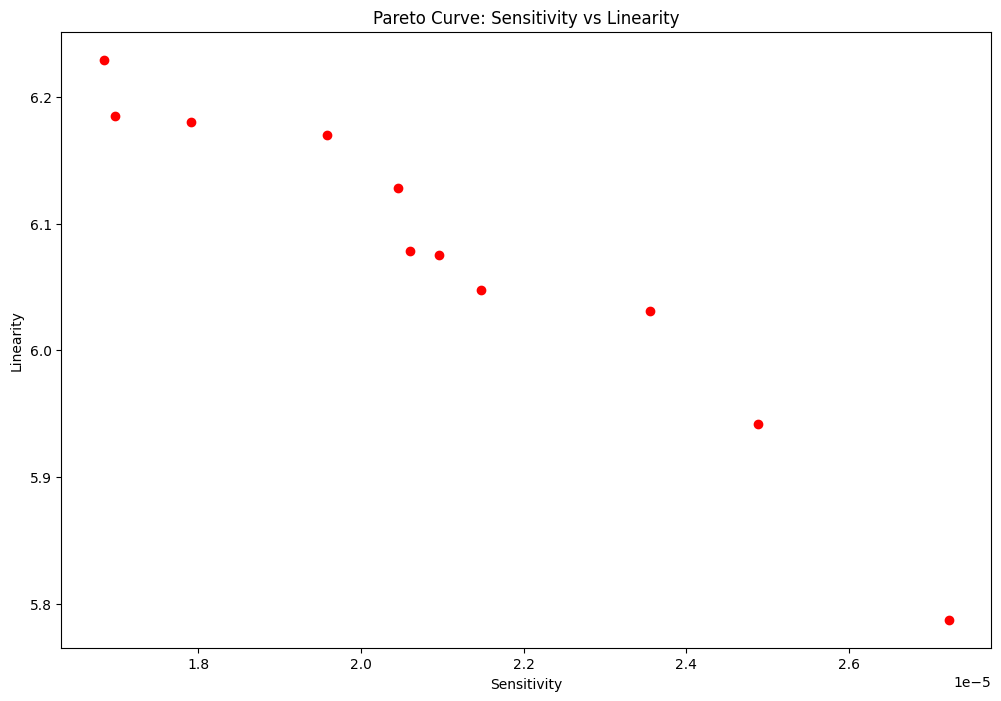

In [25]:
plot(gbest)

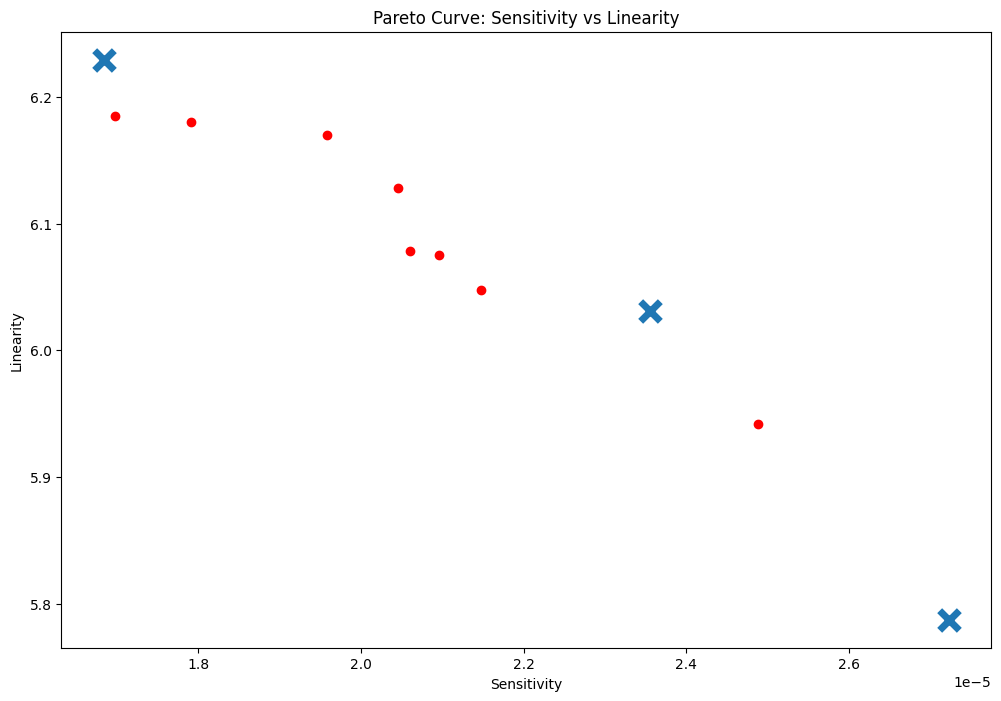

In [26]:
sensitivity = [particle["cost"][0] for particle in gbest]
linearity = [particle["cost"][1] for particle in gbest]

sorted_particles = sorted(gbest, key=lambda particle: particle["cost"][0])

knee_point = find_knee_point(sorted_particles)

sorted_particles = [sorted_particles[0], knee_point, sorted_particles[-1]]

paretto_sensitivity = [particle["cost"][0] for particle in sorted_particles]
paretto_linearity = [particle["cost"][1] for particle in sorted_particles]

# Plotting the Pareto chart
plt.figure(figsize=(12, 8))
plt.scatter(sensitivity, linearity, marker="o", color="r")
plt.scatter(paretto_sensitivity, paretto_linearity, s=200, linewidths=5, marker="x")
plt.xlabel("Sensitivity")
plt.ylabel("Linearity")
plt.title("Pareto Curve: Sensitivity vs Linearity")
plt.show()